# ⚠️ Work in Progress ⚠️

**This report is just a draft. It is based solely on the repos covered by Protocol Guild members. It is not an exhaustive mapping of all the projects Protocol Guild members are contributing to. Nor does it capture the off-GitHub contributions those members are making to the Ethereum protocol and research community.**

In [1]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scripts.github import is_fork
from scripts.oso_db import (
    execute_query, 
    execute_saved_query, 
    query_and_dump_to_csv
)
from scripts.processing import (
    github_event_processor, 
    github_active_developers, 
    github_repos_analysis,
    github_network_graph
)

from visualizations.contribution_heatmap import contribution_heatmap
from visualizations.network_graph import network_graph
from visualizations.stacked_area import activity_plot


DPI = 144 
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = DPI
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Fetch / update data

In [2]:
data_path = "data/2023-10-16_events_by_collection_namespace_protocol-guild_GITHUB.csv"
START_DATE = '2015-01-01'
END_DATE = '2023-10-01'

In [3]:
# uncomment this to grab fresh data

# with open("data/2023-10-15_forks.json") as f:
#     forks_data = json.load(f)

# forks_list = [repo for repo, status in forks_data.items() if status==True]

# result = execute_saved_query("events_by_collection_namespace", params=["protocol-guild", "GITHUB"])
# df = github_event_processor(result, forks=forks_list)
# df.to_csv(data_path)    

In [4]:
df = pd.read_csv(data_path, index_col=0)
df = df[(df['date'] >= START_DATE) & (df['date'] < END_DATE)]
df['month'] = pd.PeriodIndex(df['event_time'], freq='M')
df.head()

,project_slug,project_name,github_repo,contributor_name,event_time,event_type,date,month,quarter
1,status-im,Status,status-im/nimbus-eth2,henridf,2022-12-21 17:47:40+00:00,PULL_REQUEST_CREATED,2022-12-21,2022-12,2022Q4
2,status-im,Status,status-im/nimbus-eth2,tersec,2022-12-15 08:53:35+00:00,PULL_REQUEST_CREATED,2022-12-15,2022-12,2022Q4
3,status-im,Status,status-im/nimbus-eth2,zah,2022-12-19 13:02:18+00:00,PULL_REQUEST_CREATED,2022-12-19,2022-12,2022Q4
4,lighthouse-sigp,Lighthouse by Sigma Prime,sigp/lighthouse,pawanjay176,2022-12-15 06:55:31+00:00,PULL_REQUEST_CREATED,2022-12-15,2022-12,2022Q4
5,lighthouse-sigp,Lighthouse by Sigma Prime,sigp/lighthouse,jimmygchen,2022-12-15 07:31:14+00:00,PULL_REQUEST_CREATED,2022-12-15,2022-12,2022Q4


# Basic analysis

In [5]:
# first commit
df[df['event_type'] == 'COMMIT_CODE']['event_time'].min()

'2015-02-10 04:56:17+00:00'

In [6]:
# total commits
len(df[df['event_type'] == 'COMMIT_CODE'])

26248

<AxesSubplot:xlabel='month'>

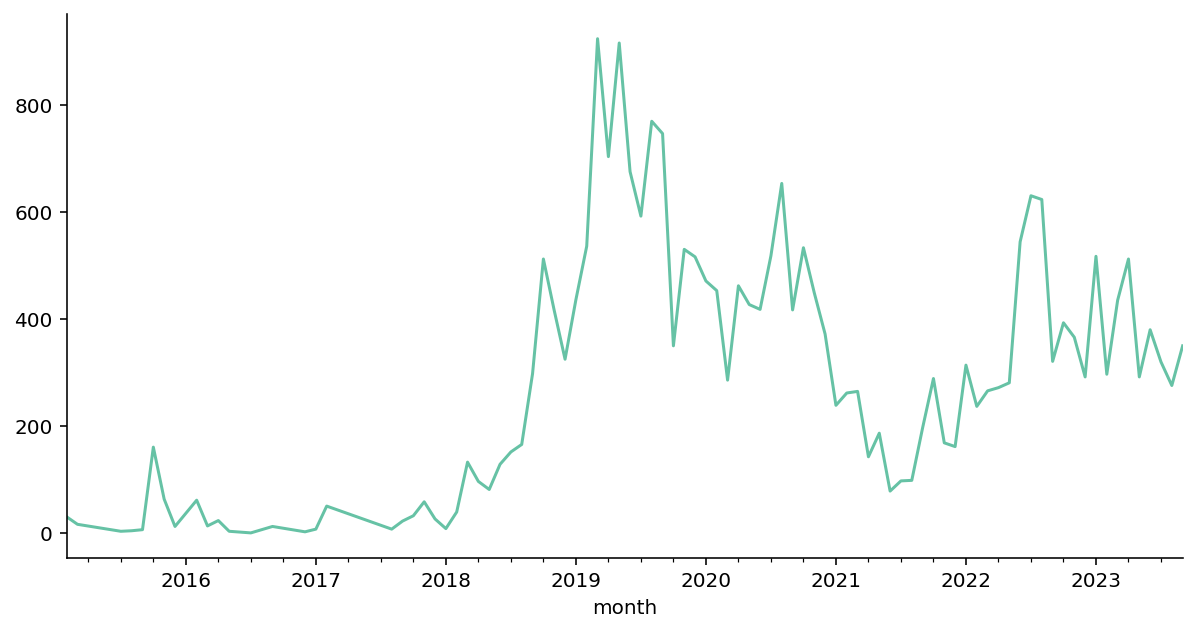

In [7]:
df[df['event_type'] == 'COMMIT_CODE'].groupby('month')['event_time'].count().plot()

In [8]:
# total devs
len(df[df['event_type'] == 'COMMIT_CODE']['contributor_name'].unique())

430

In [9]:
# original repos
len(df['github_repo'].unique())

218

# Aggregate trends

<AxesSubplot:ylabel='Developers'>

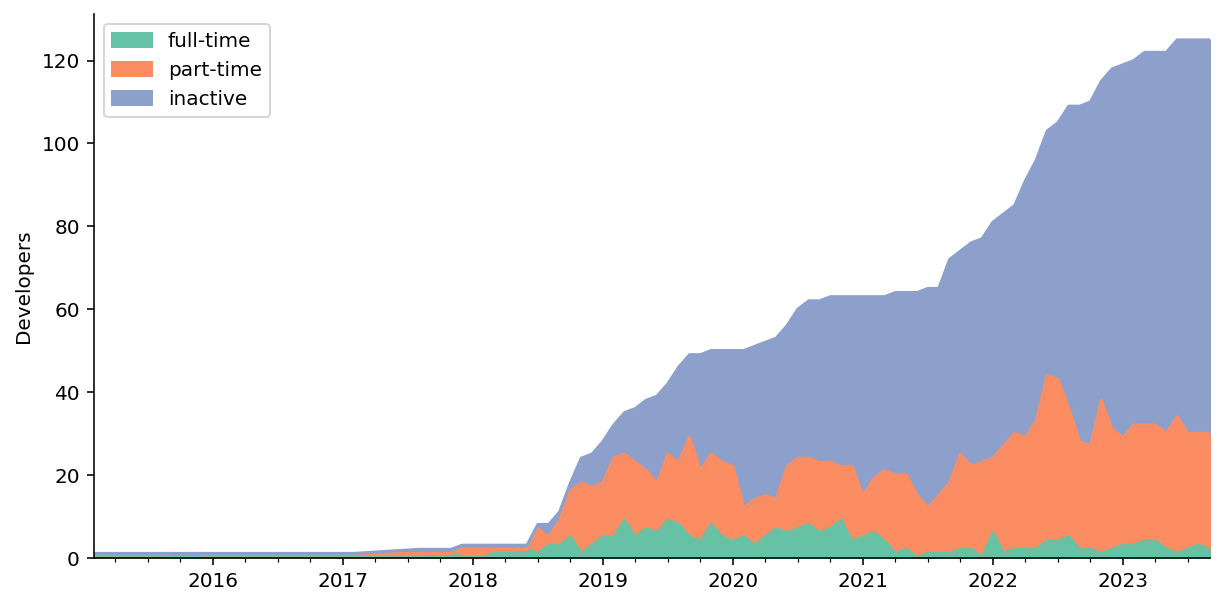

In [10]:
DEVS_EVENTS = ['COMMIT_CODE']
devs = github_active_developers(df, event_filters=DEVS_EVENTS, min_days=10)
devs.T.plot(kind='area', ylabel='Developers', xlabel="")

<AxesSubplot:ylabel='Developers'>

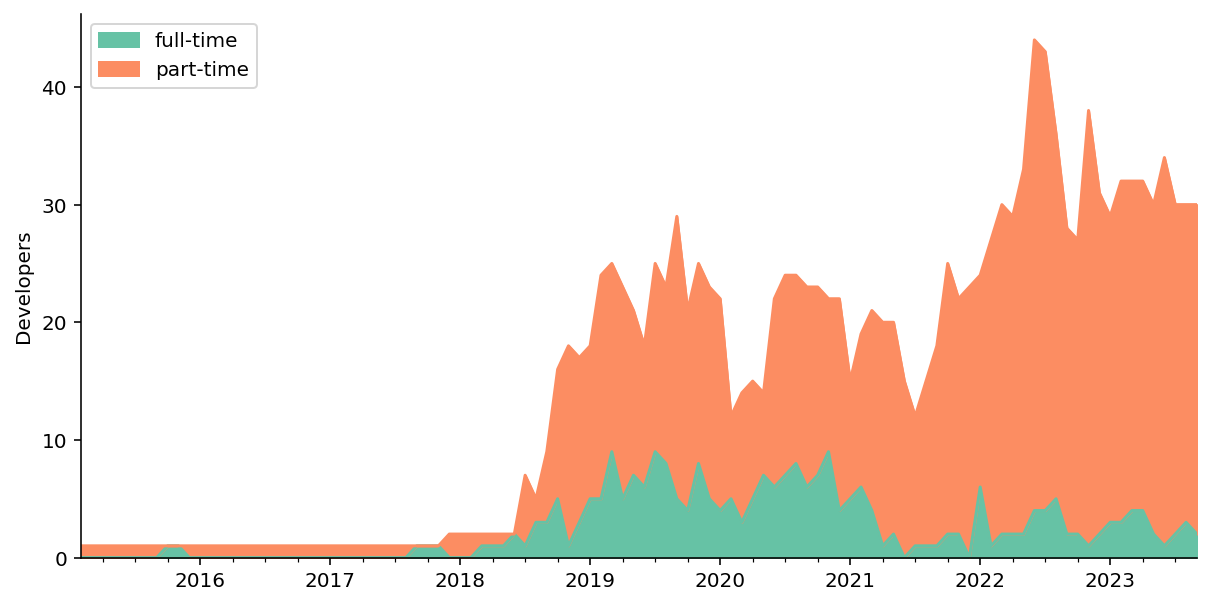

In [11]:
devs.T[['full-time', 'part-time']].plot(kind='area', ylabel='Developers', xlabel="")

<AxesSubplot:ylabel='Maintainers'>

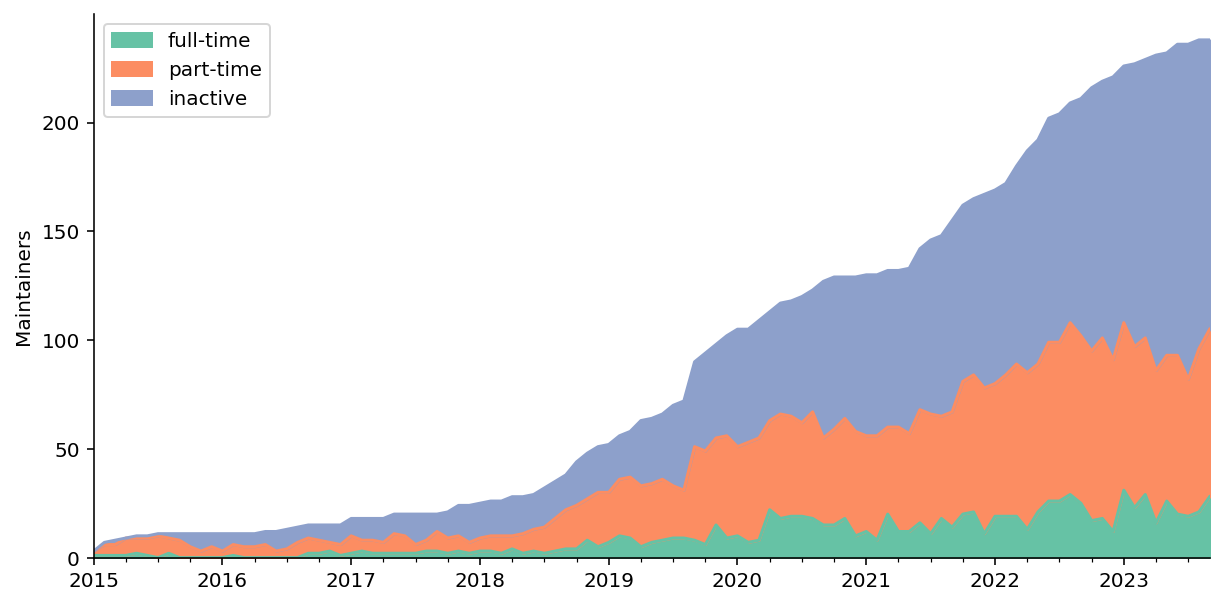

In [12]:
MAINTAINERS_EVENTS = ['PULL_REQUEST_APPROVED', 'ISSUE_CLOSED']
maintainers = github_active_developers(df, event_filters=MAINTAINERS_EVENTS, min_days=10)
maintainers.T.plot(kind='area', ylabel='Maintainers', xlabel="")

<AxesSubplot:ylabel='Contributors'>

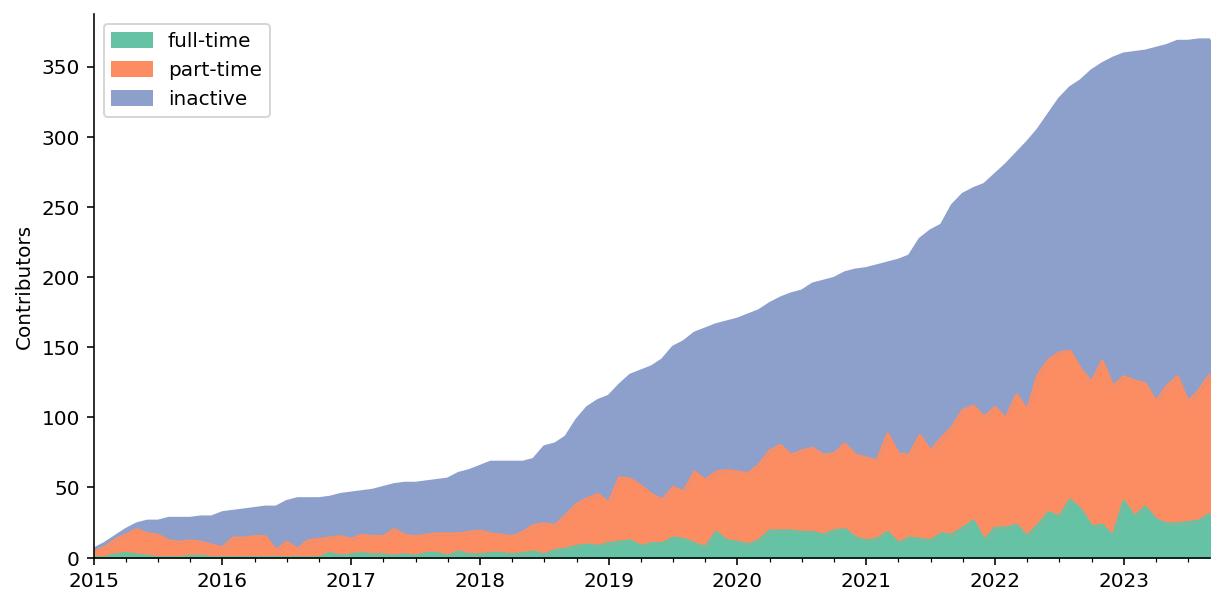

In [13]:
CONTRIBUTORS_EVENTS = ['COMMIT_CODE', 'PULL_REQUEST_APPROVED', 'ISSUE_CREATED']
contributors = github_active_developers(df, event_filters=CONTRIBUTORS_EVENTS, min_days=10)
contributors.T.plot(kind='area', ylabel='Contributors', xlabel="")

<AxesSubplot:ylabel='Contributors'>

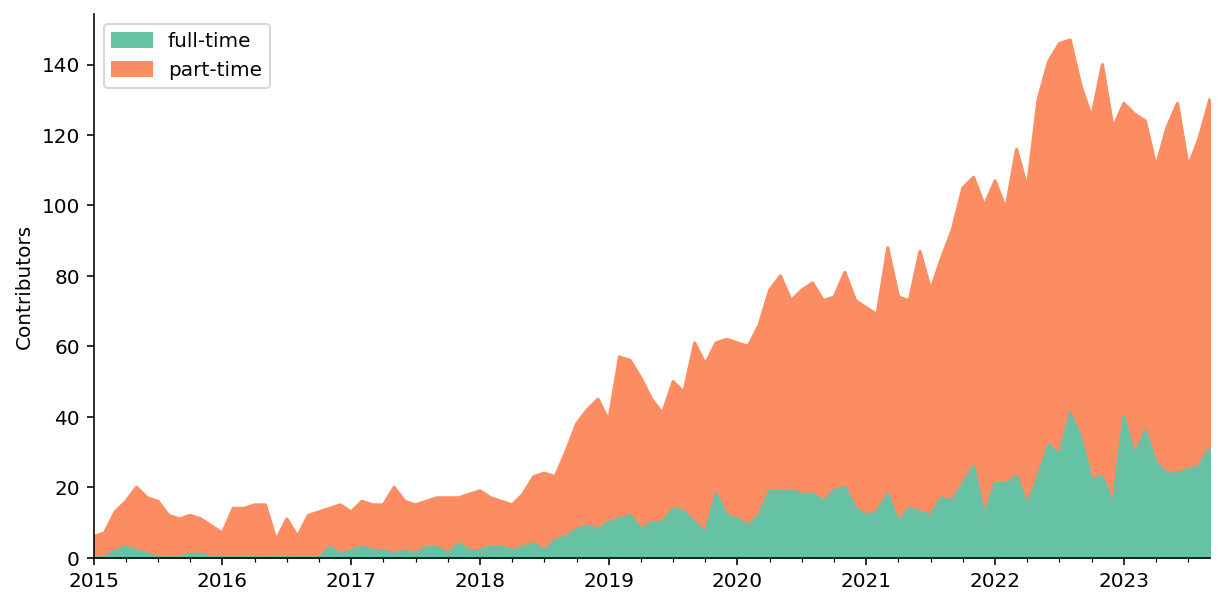

In [14]:
contributors.T[['full-time', 'part-time']].plot(kind='area', ylabel='Contributors', xlabel="")

(<Figure size 3000x1500 with 1 Axes>,
 <AxesSubplot:ylabel='Total Contributions'>)

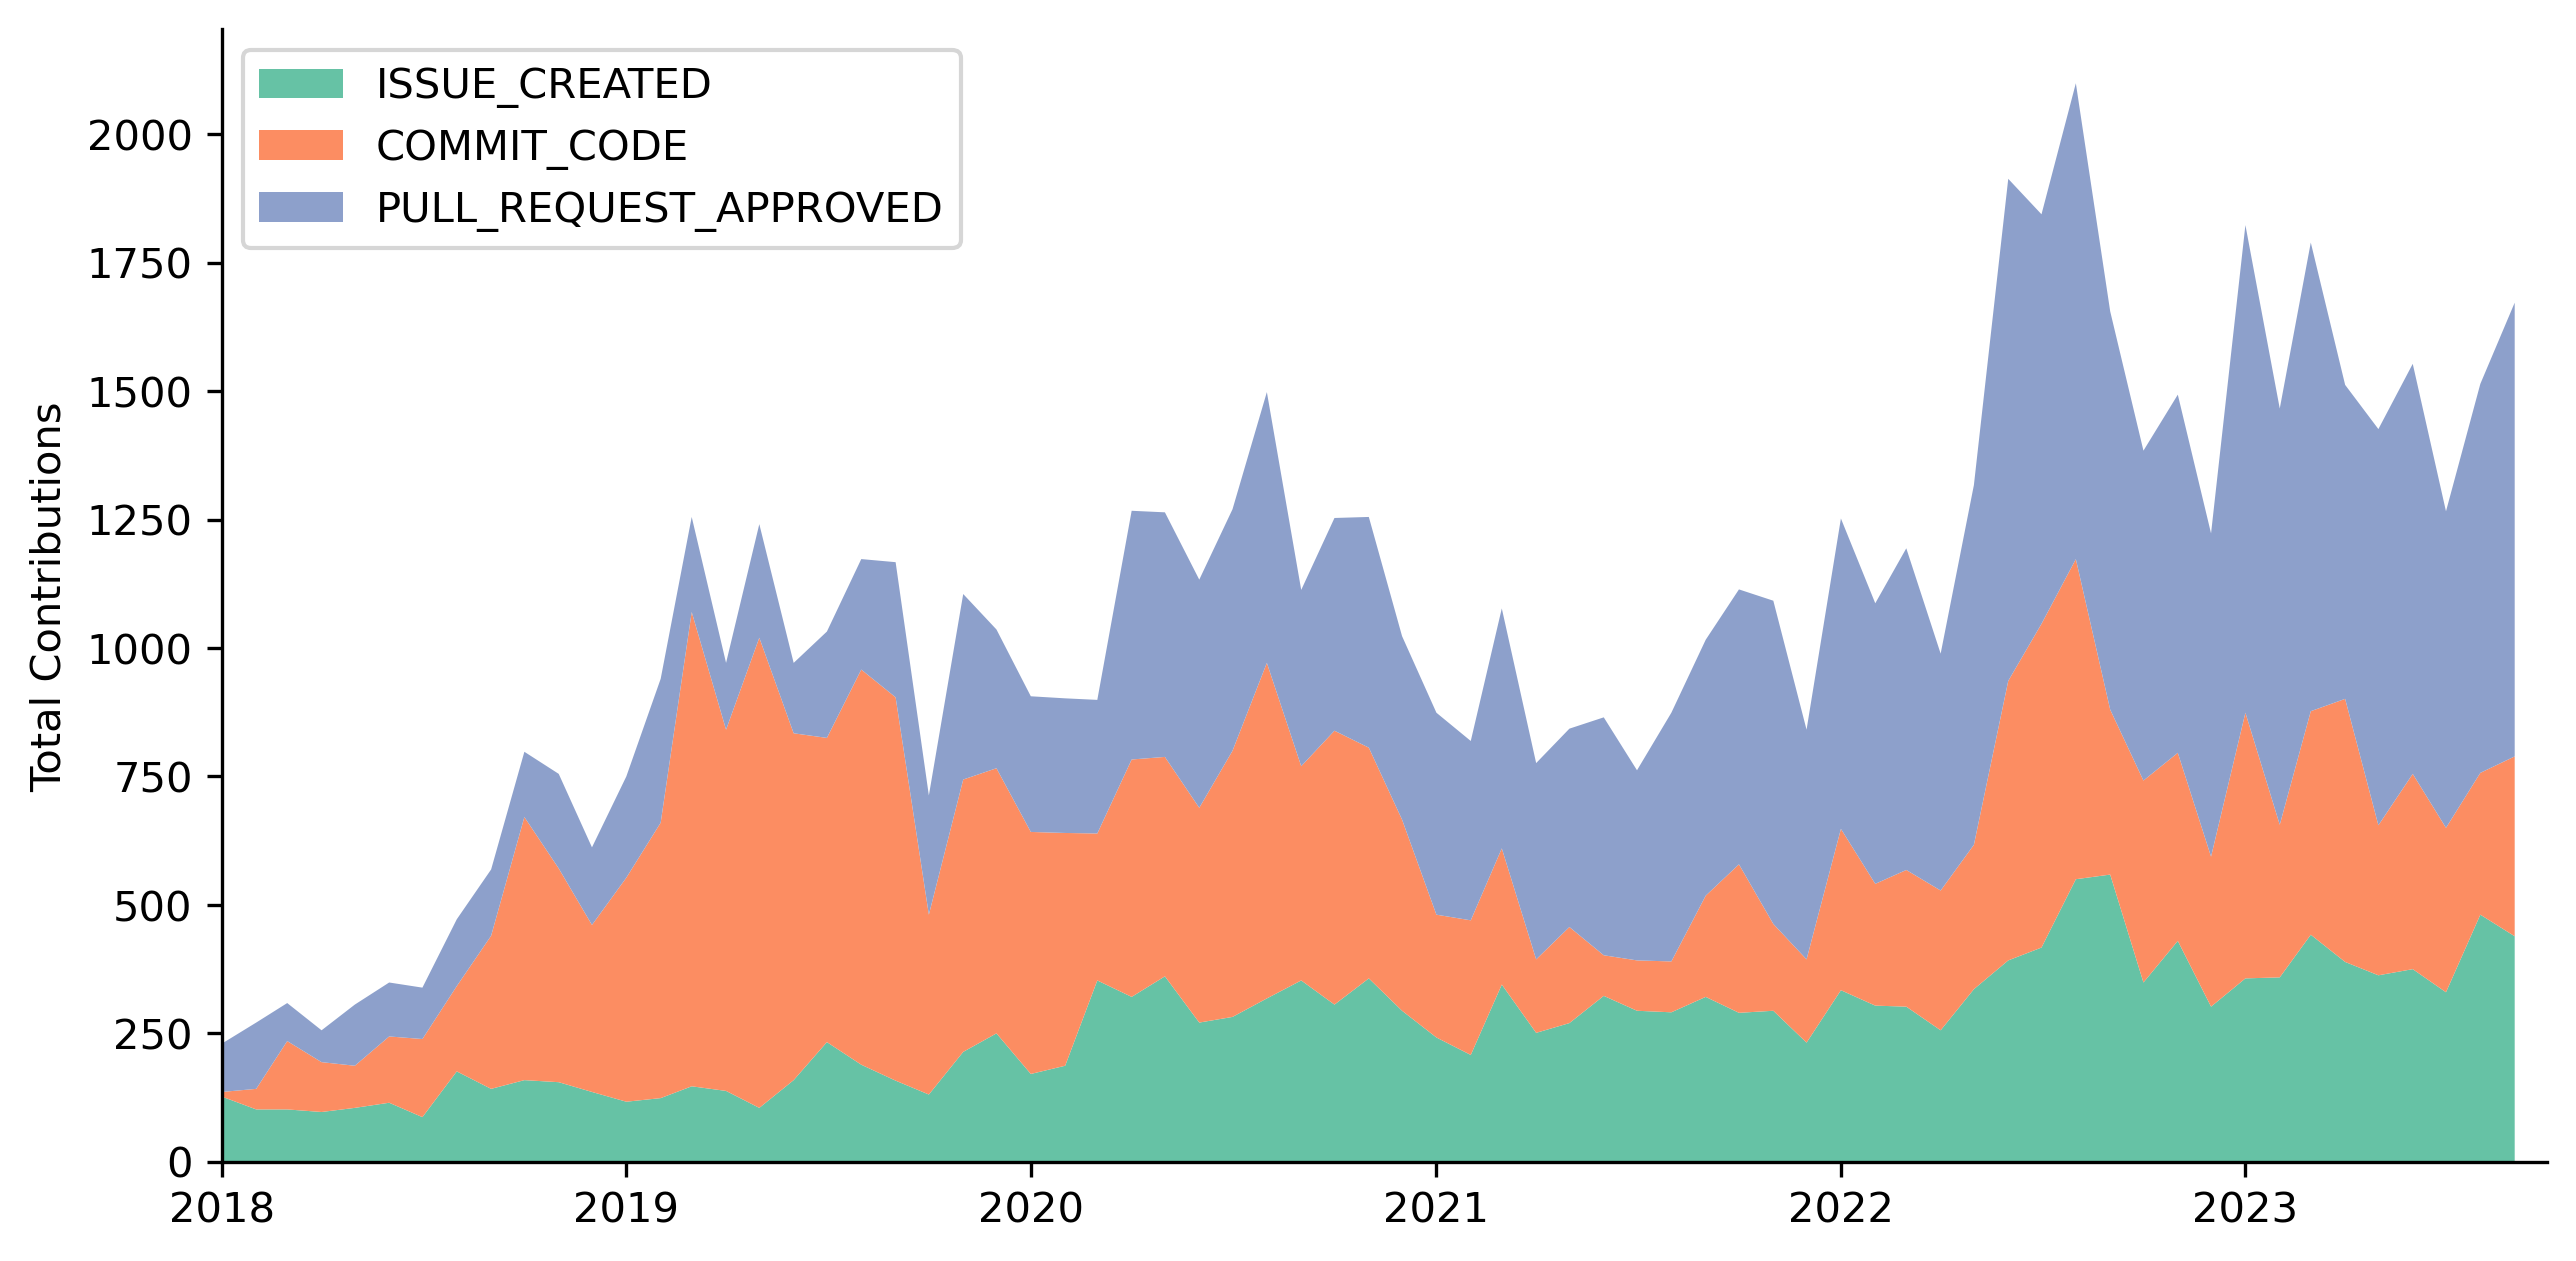

In [15]:
activity_plot(
    df, 
    grouper_col='event_type', 
    date_col='month', 
    start_date='2018-01-01',
    end_date='2023-09-30',
    filter_vals=CONTRIBUTORS_EVENTS
)

# Repo analysis

In [16]:
rdf = github_repos_analysis(df, groupers=['project_name', 'github_repo'])    
rdf.sort_values(by='stars_count', ascending=False).head(10)

,,num_repos,first_date,last_date,stars_count,days_since_first_commit,days_since_last_commit,last_commit_category,stars_category,project_age
project_name,github_repo,,,,,,,,,
geth,ethereum/go-ethereum,1,2015-01-01,2023-09-30,43474.0,3194,0,active,very popular,> 4 years old
Erigon,ledgerwatch/erigon,1,2019-05-28,2023-09-30,2582.0,1586,0,active,very popular,> 4 years old
Lighthouse by Sigma Prime,sigp/lighthouse,1,2018-07-06,2023-09-30,2526.0,1912,0,active,very popular,> 4 years old
Hyperledger Besu,hyperledger/besu,1,2018-10-09,2023-09-30,1270.0,1817,0,active,very popular,> 4 years old
Nethermind,NethermindEth/nethermind,1,2017-08-23,2023-09-30,977.0,2229,0,active,more popular,> 4 years old
Lodestar,ChainSafe/lodestar,1,2018-06-22,2023-09-30,962.0,1926,0,active,more popular,> 4 years old
Nethermind,NethermindEth/warp,1,2021-07-17,2023-09-22,766.0,805,8,active,more popular,2-4 years old
Status,status-im/nimbus-eth2,1,2018-07-20,2023-09-30,457.0,1898,0,active,more popular,> 4 years old
Nethermind,NethermindEth/juno,1,2022-01-25,2023-09-29,250.0,613,1,active,more popular,< 2 years


In [17]:
pd.crosstab(rdf['last_commit_category'], rdf['stars_category'])

stars_category,less popular,more popular,very popular
last_commit_category,,,
active,17,30,4
dormant,7,6,0
inactive,36,13,0


In [18]:
pd.crosstab(rdf['project_age'], rdf['stars_category'])

stars_category,less popular,more popular,very popular
project_age,,,
< 2 years,37,26,0
2-4 years old,13,12,0
> 4 years old,10,11,4


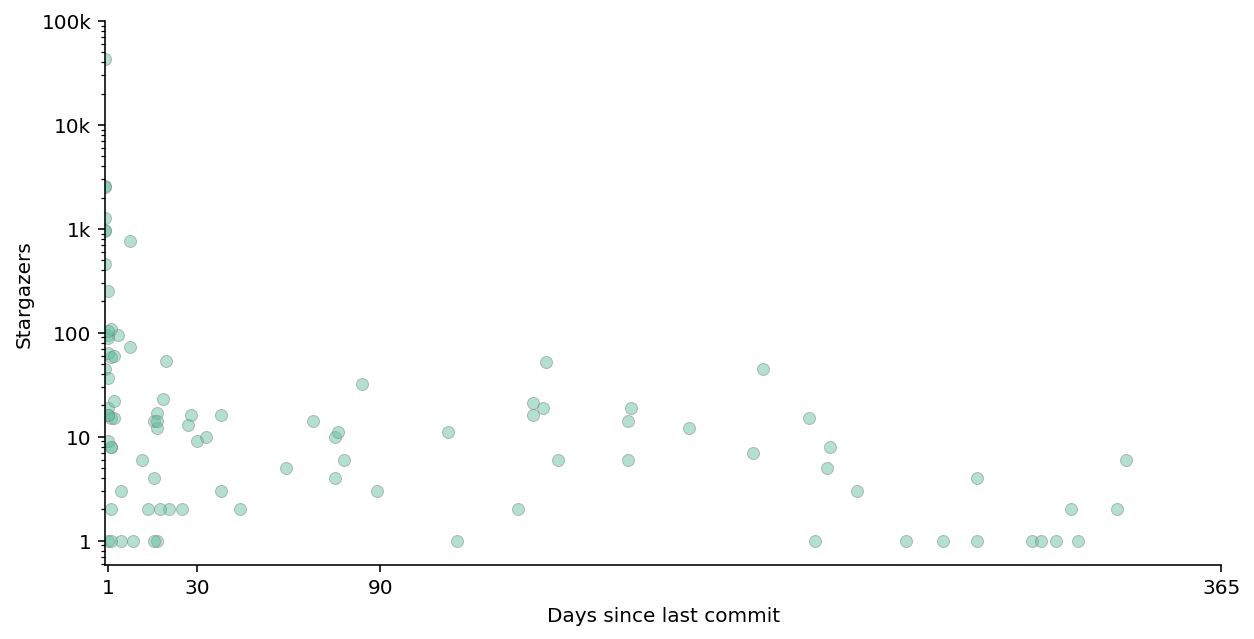

In [19]:
fig = sns.scatterplot(
    data=rdf,
    x='days_since_last_commit',
    y='stars_count',
    legend=False,
    alpha=.5,
    edgecolor='grey'
)
fig.set(
    yscale='log',  
    ylim=(0,100000), xlim=(0,365), 
    ylabel='Stargazers', xlabel='Days since last commit',
    xticks=[1,30,90,365],
    yticks=[1,10,100,1000,10000,100000],
    yticklabels=[1,10,100,"1k","10k","100k"]
)
sns.despine()

# Heatmapping

In [20]:
dff = df[df['event_type'].isin(CONTRIBUTORS_EVENTS)]

(<Figure size 3024x748.8 with 1 Axes>, <AxesSubplot:>)

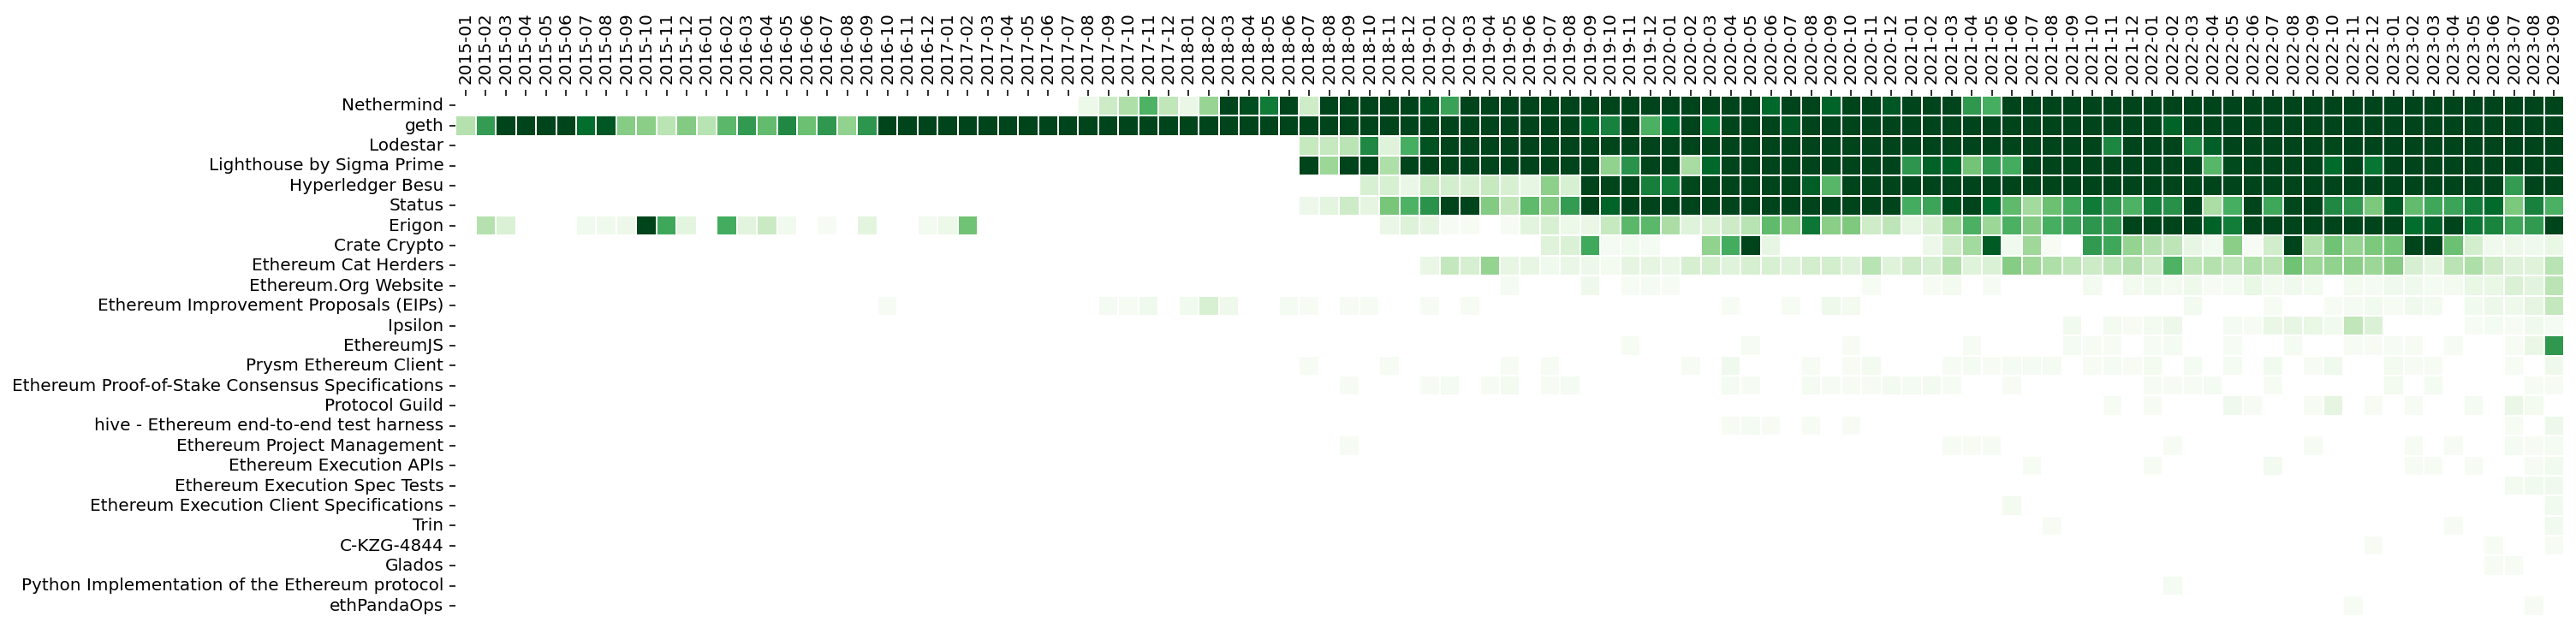

In [21]:
contribution_heatmap(
    dff,
    index_col='project_name',
    column_col='month',
    value_col='event_time',
    apply_groupby=True,
    vmax=100,
    sort_label_method='mean',
    dpi=DPI
)

(<Figure size 3024x5875.2 with 1 Axes>, <AxesSubplot:>)

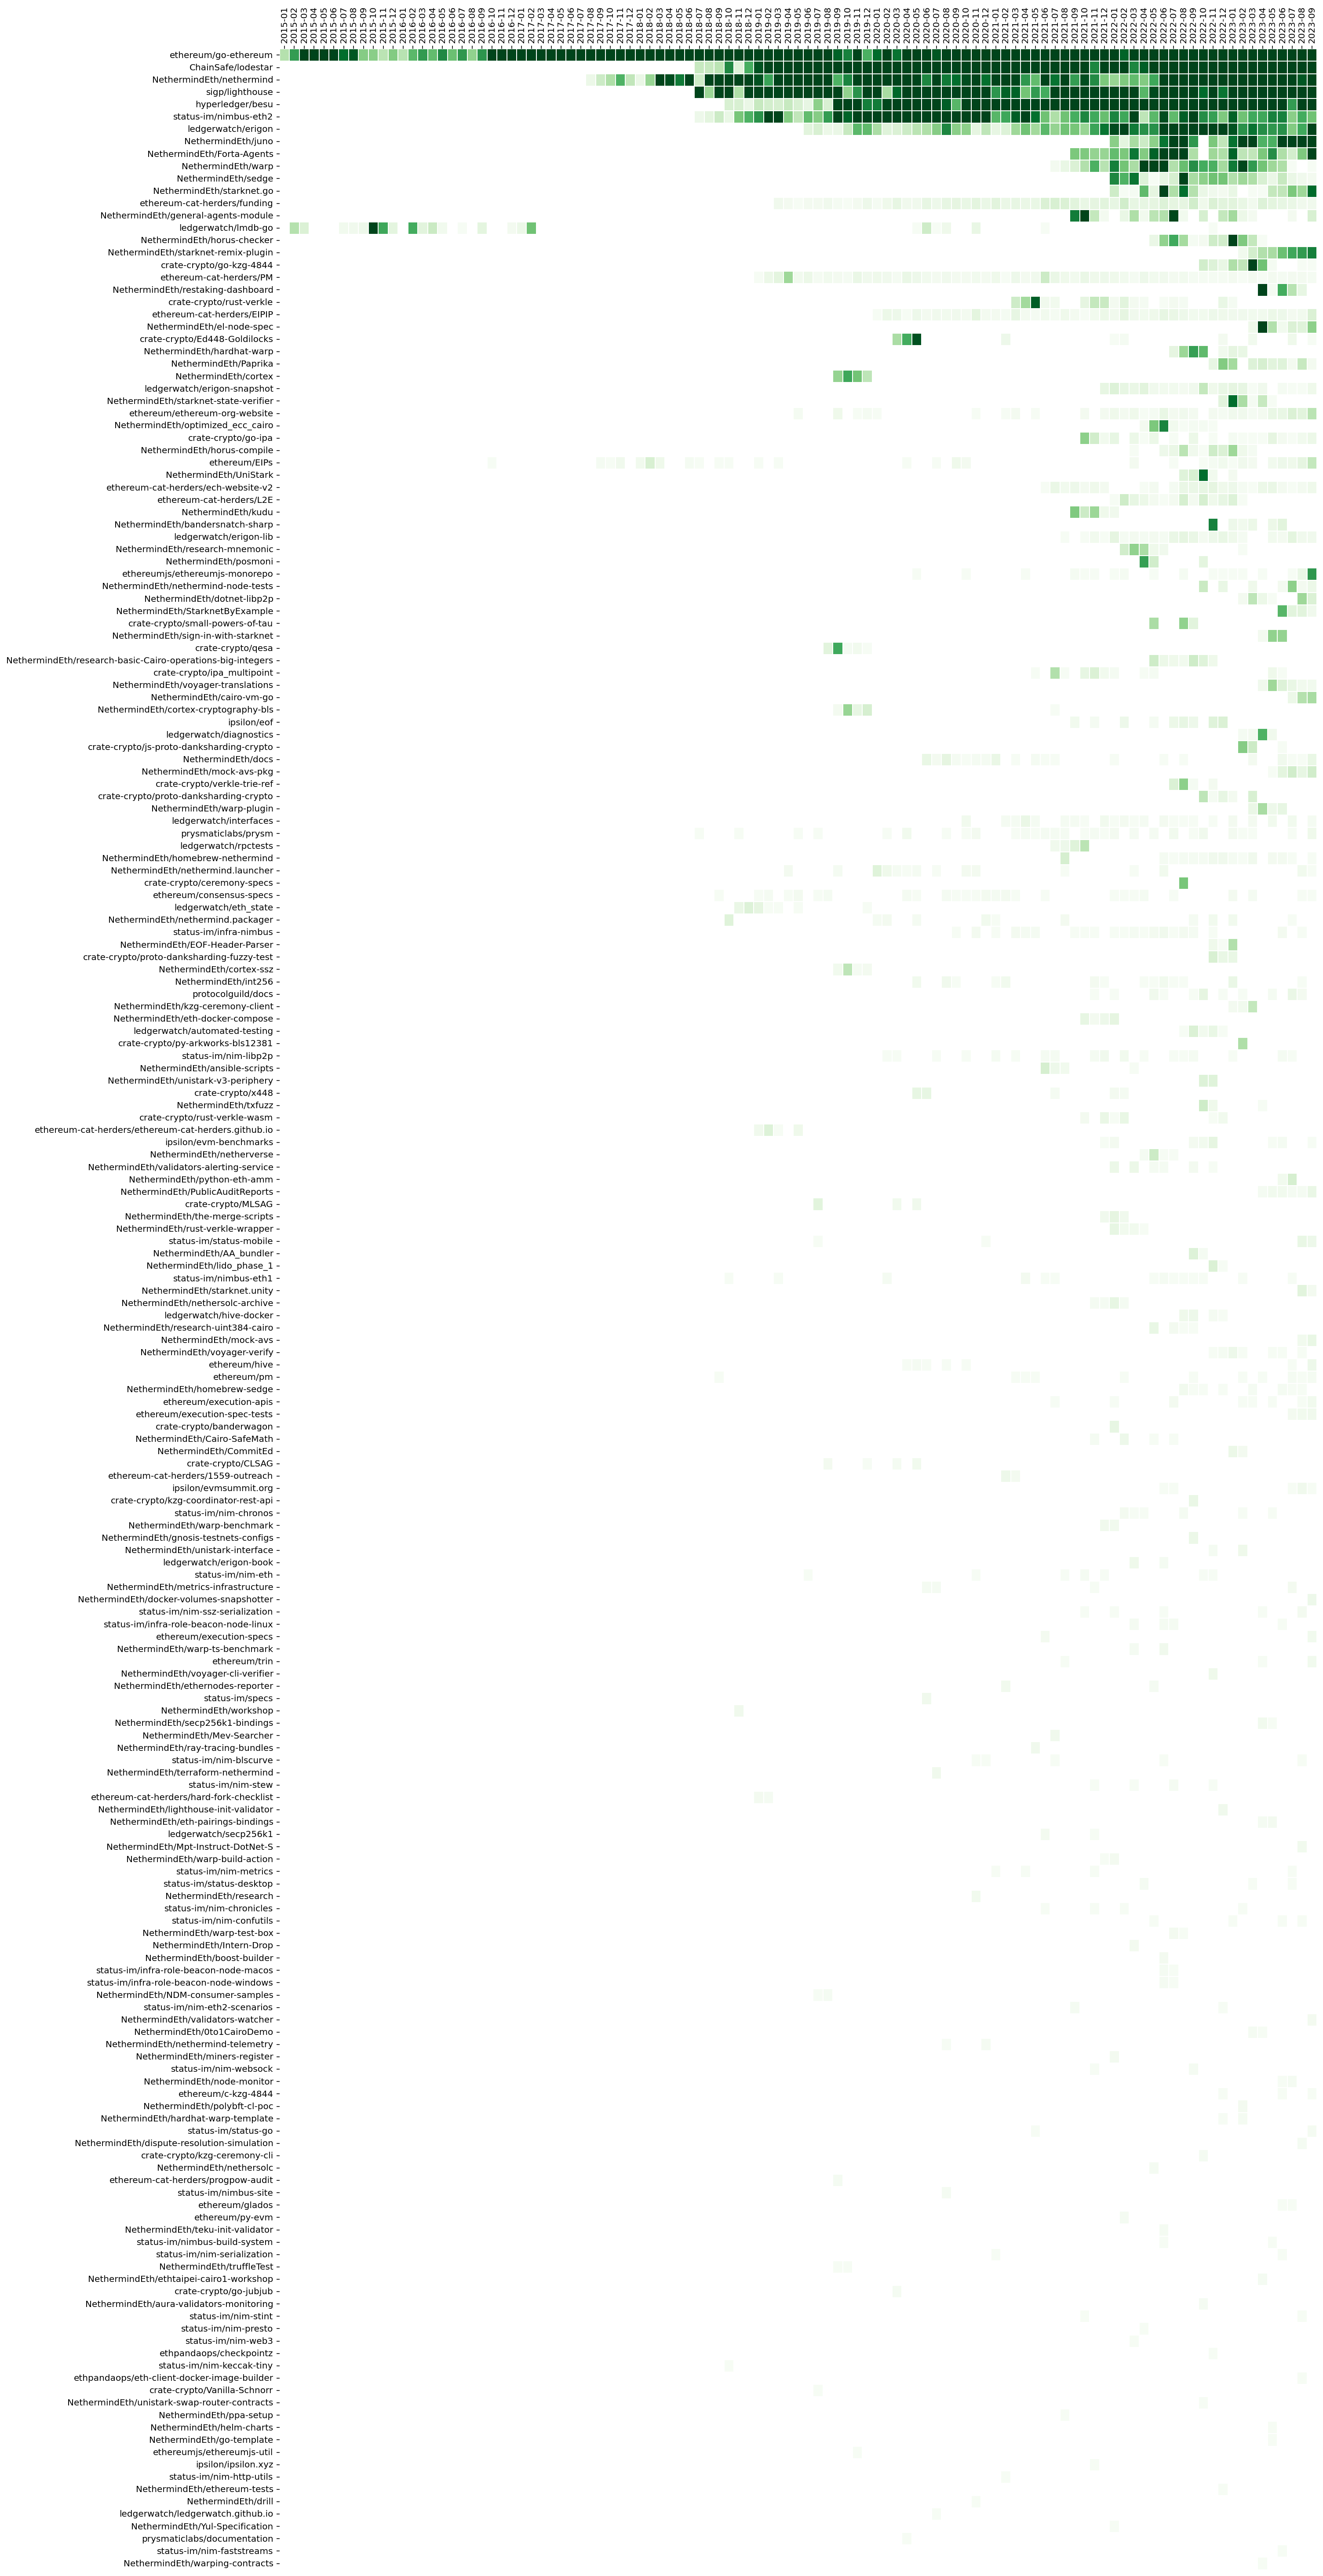

In [22]:
contribution_heatmap(
    dff,
    index_col='github_repo',
    column_col='month',
    value_col='event_time',
    apply_groupby=True,
    vmax=100,
    sort_label_method='mean',
    dpi=DPI
)

# "Leaderboard"

(<Figure size 2995.2x2793.6 with 1 Axes>, <AxesSubplot:>)

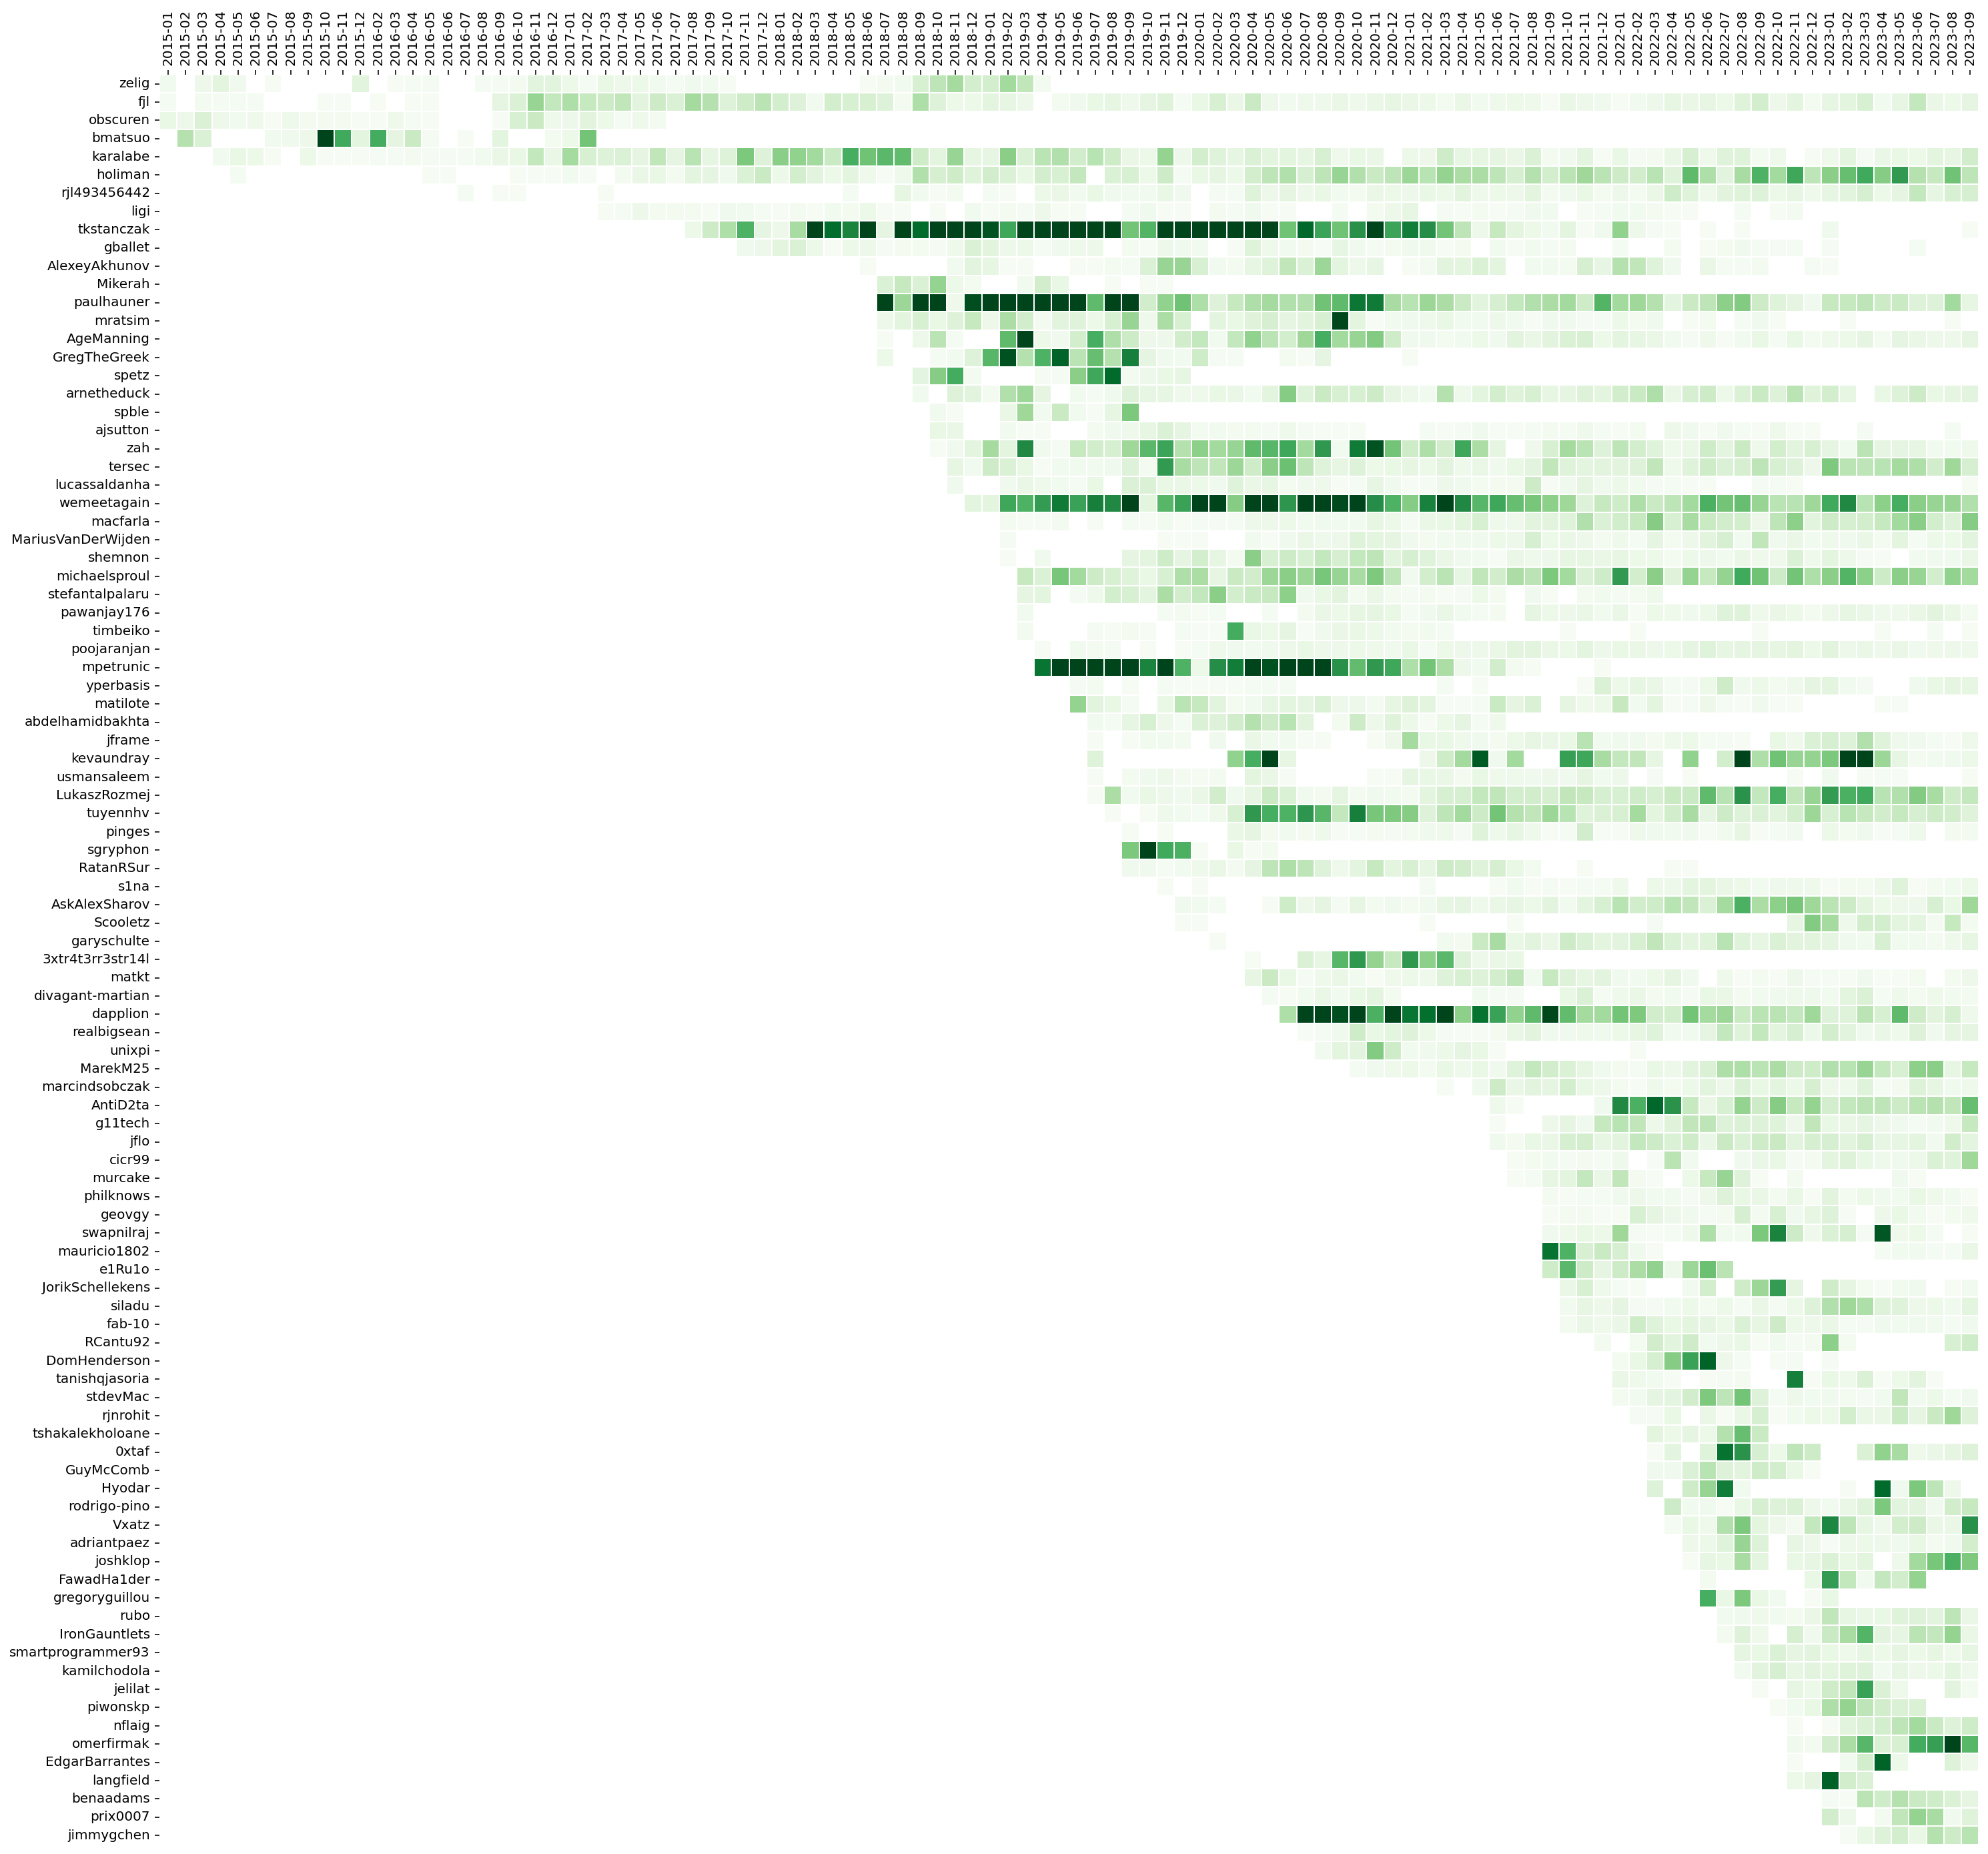

In [23]:
num_projects_contributed_to = 1
eligible_contribs = dff.groupby('contributor_name')['project_slug'].nunique()
eligible_contribs = eligible_contribs[eligible_contribs >= num_projects_contributed_to].index

top_contribs = dff[dff['contributor_name'].isin(eligible_contribs)]['contributor_name'].value_counts()
top_contribs = top_contribs.head(100).index
top_contribs = [c for c in top_contribs if "@" not in c]

contribution_heatmap(
    dff[dff.contributor_name.isin(top_contribs)],
    index_col='contributor_name',
    column_col='month',
    value_col='event_time',
    apply_groupby=True,
    vmax=100,
    dpi=DPI
)

(<Figure size 950.4x1440 with 1 Axes>, <AxesSubplot:>)

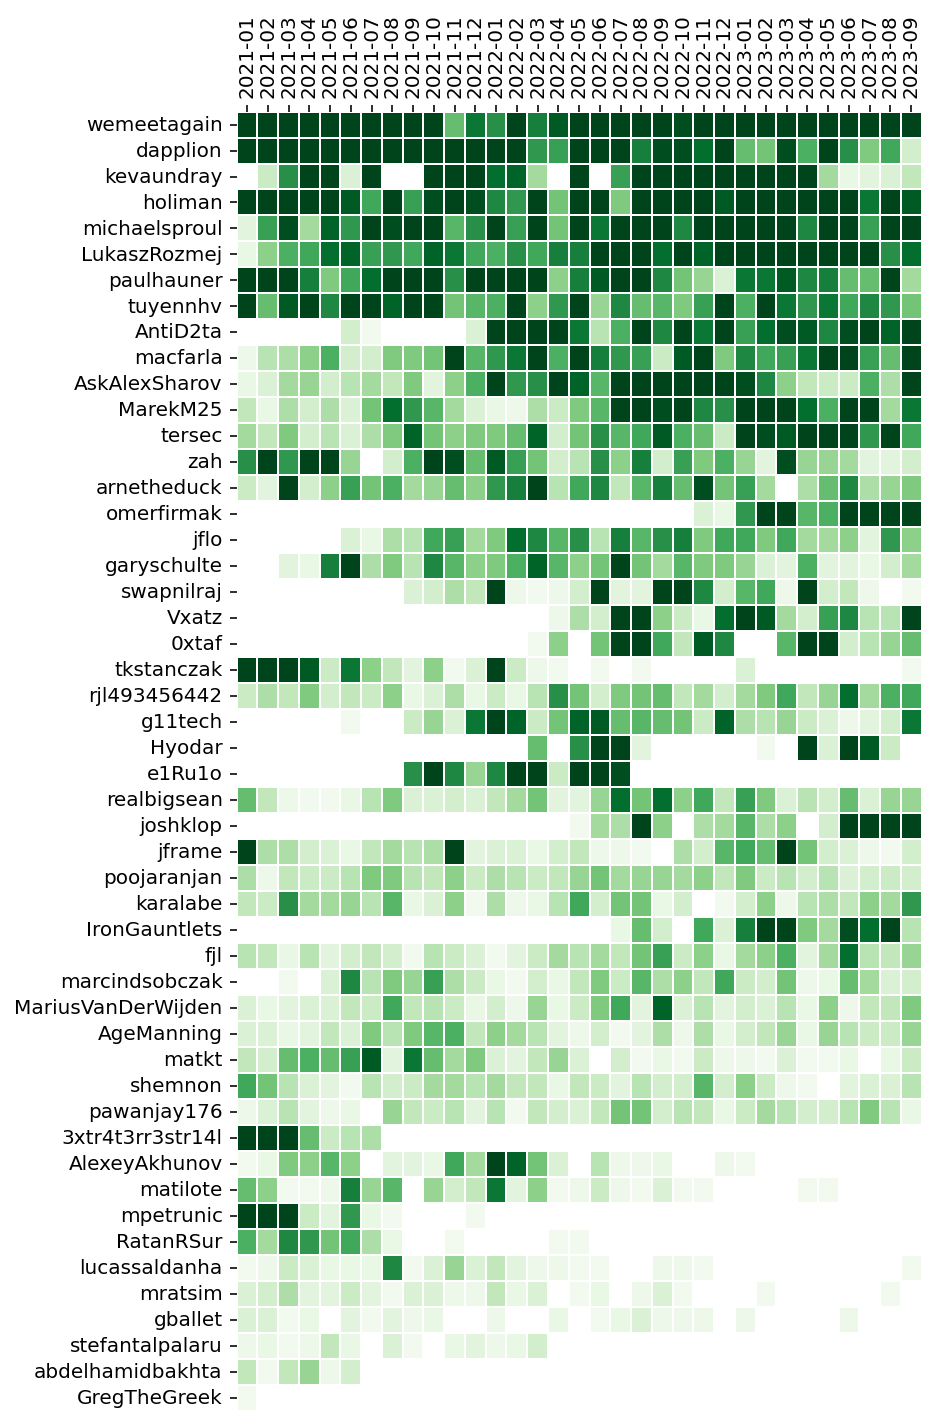

In [24]:
num_projects_contributed_to = 1
eligible_contribs = dff[dff.event_time >= '2021-01-01'].groupby('contributor_name')['project_slug'].nunique()
eligible_contribs = eligible_contribs[eligible_contribs >= num_projects_contributed_to].index

top_contribs = dff[dff['contributor_name'].isin(eligible_contribs)]['contributor_name'].value_counts()
top_contribs = top_contribs.head(50).index
top_contribs = [c for c in top_contribs if "@" not in c]

contribution_heatmap(
    dff[dff.contributor_name.isin(top_contribs) & (dff.event_time >= '2021-01-01')],
    index_col='contributor_name',
    column_col='month',
    value_col='event_time',
    apply_groupby=True,
    vmax=30,
    dpi=DPI,
    sort_label_method='mean'
)

(<Figure size 1440x1440 with 1 Axes>,
 <AxesSubplot:title={'center':'Projects with Common Contributors'}>)

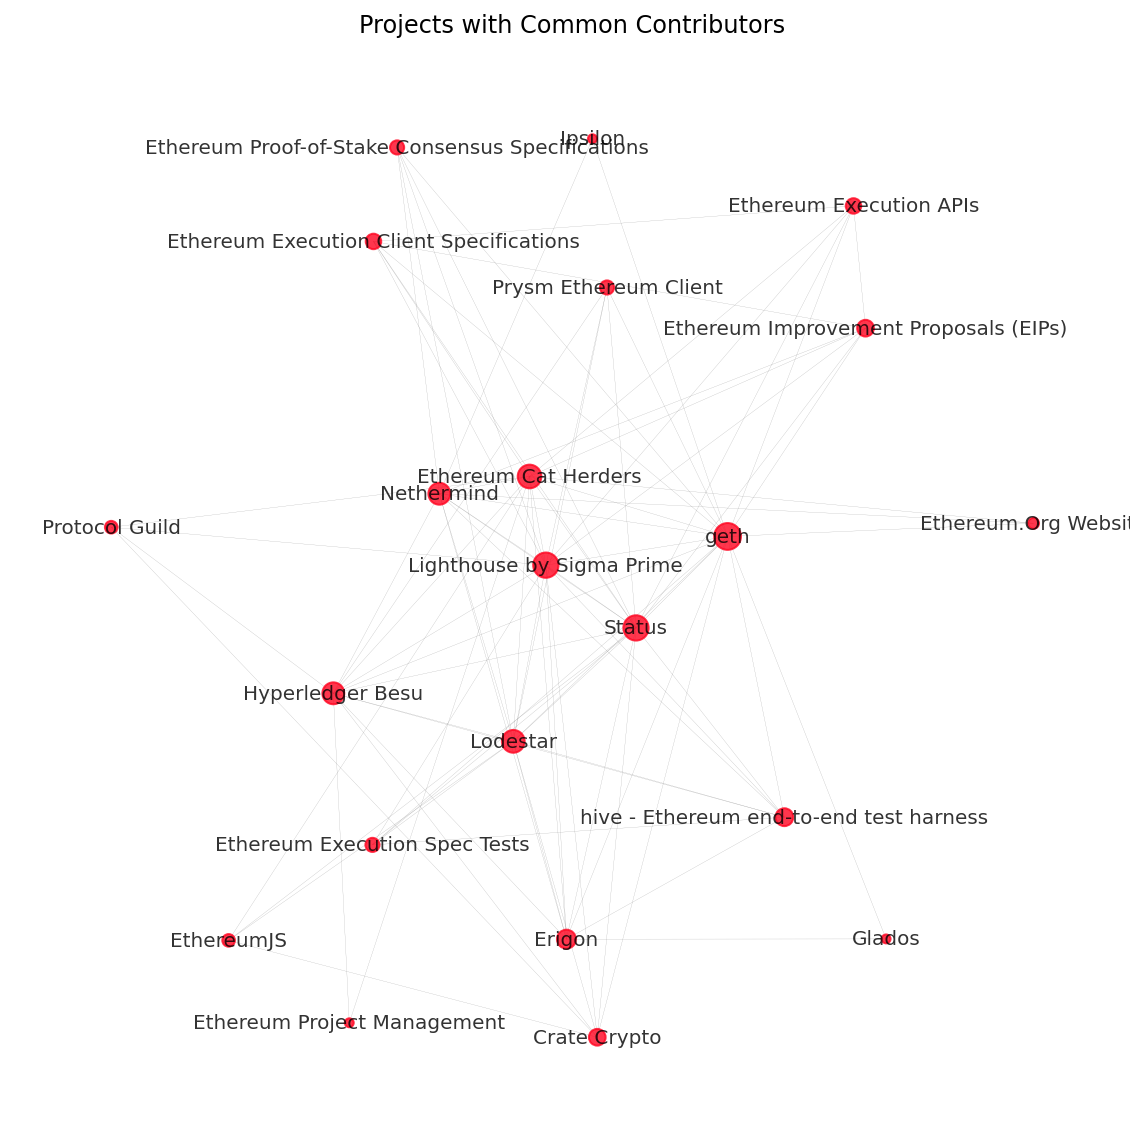

In [25]:
nodes, edges = github_network_graph(dff)
network_graph(
    nodes, edges, 
    figsize=(10,10), # looks best at (30,30)
    dpi=DPI,         # looks best at 500
    scale=1, 
    k=(10/(len(nodes)**.5)),
    min_degree=2,
    styling=dict(
        with_labels=True, 
        font_size=10, 
        font_color='black', 
        node_color='#FF0420', 
        alpha=.8,
        edge_color='grey',
        width=.1,
    )
)